In [ ]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 4. 인플루언서 YouTuber 되기 실습
# Fast Campus / (주)데이원컴퍼니

# **1. 모듈 설치 및 호출**

In [1]:
!pip install geneticalgorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.3 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=fe15e5a25bb7e61793aa4aa2eae11a572236d3b5e02aac355ee3261e1ec20996
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [2]:
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint

import chardet
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm


pd.set_option('display.max_columns', None)

# **2. 데이터 로드 및 탐색적 데이터 분석**

In [3]:
# KRvideos.csv 데이터 파일을 Colab에 업로드
# Data link: https://www.kaggle.com/datasnaek/youtube-new
# 여러 나라 data file중 한국 데이터 (KRvideos.csv) 사용

from google.colab import files, drive
file_uploaded = files.upload()

Saving KRvideos.csv to KRvideos.csv


In [4]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
! ls /content

KRvideos.csv  sample_data


In [5]:
filename = '/content/KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: UTF-8-SIG


In [6]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [7]:
# KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                34567 non-null  object
 1   trending_date           34567 non-null  object
 2   title                   34567 non-null  object
 3   channel_title           34567 non-null  object
 4   category_id             34567 non-null  int64 
 5   publish_time            34567 non-null  object
 6   tags                    34567 non-null  object
 7   views                   34567 non-null  int64 
 8   likes                   34567 non-null  int64 
 9   dislikes                34567 non-null  int64 
 10  comment_count           34567 non-null  int64 
 11  thumbnail_link          34567 non-null  object
 12  comments_disabled       34567 non-null  bool  
 13  ratings_disabled        34567 non-null  bool  
 14  video_error_or_removed  34567 non-null  bool  
 15  de

In [8]:
raw_data['description'].isnull().sum()

5493

In [9]:
raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum()

511

In [10]:
raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum()

1400

In [11]:
raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum()

41

In [12]:
for i in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts())
    print('\n')

video_id
True     20563
False    16334
Name: video_id, dtype: int64


trending_date
True     36623
False      274
Name: trending_date, dtype: int64


title
True     20529
False    16368
Name: title, dtype: int64


channel_title
True     32849
False     4048
Name: channel_title, dtype: int64


category_id
True     36875
False       22
Name: category_id, dtype: int64


publish_time
True     21033
False    15864
Name: publish_time, dtype: int64


tags
True     26104
False    10793
Name: tags, dtype: int64


views
False    30692
True      6205
Name: views, dtype: int64


likes
True     27421
False     9476
Name: likes, dtype: int64


dislikes
True     34820
False     2077
Name: dislikes, dtype: int64


comment_count
True     32206
False     4691
Name: comment_count, dtype: int64


thumbnail_link
True     20806
False    16091
Name: thumbnail_link, dtype: int64


comments_disabled
True     36894
False        3
Name: comments_disabled, dtype: int64


ratings_disabled
True     36894
False     

In [13]:
df = raw_data[raw_data['comments_disabled'] != 1]
df = df[df['ratings_disabled'] != 1]
df = df[df['video_error_or_removed'] != 1]
df = df[df['tags'] != '[none]']
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [14]:
print('Before dropna:', len(df))
df = df.dropna()
print('After  dropna:', len(df))
df = df.reset_index(drop=True)

Before dropna: 28408
After  dropna: 24768


#**3. 피쳐 엔지니어링**

In [15]:
r_avg = []
g_avg = []
b_avg = []

for i in tqdm.tqdm(range(len(df))):
    url = df['thumbnail_link'][i]
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    red, green, blue = request_get_img.split()

    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

100%|██████████| 24768/24768 [13:23<00:00, 30.83it/s]


In [16]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


In [17]:
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('Before removing non-thumbnail images:', len(df))
df_rgb = df[df['r_avg'] != 193]
print('After  removing non-thumbnail images:', len(df_rgb))
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False)

len_check_table: 10002
Before removing non-thumbnail images: 24768
After  removing non-thumbnail images: 14889


In [18]:
df_rgb = pd.read_csv('df_color_encode.csv')

In [19]:
# df_rgb = pd.read_csv('df_color_encode.csv')
print(df['video_id'].duplicated().value_counts())
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

True     13672
False    11096
Name: video_id, dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
8666,#NAME?,18.25.03,대통령을 묻어버린 '거짓의 산' 68편 | 청와대 대변인 김의겸은 대답하라! 왜 허...,우종창의 거짓과 진실,25,2018-03-23T22:10:21.000Z,"우종창|""우종창의 거짓과 진실""|""거짓의 산""|""이지나""|""김의겸""|""이명박""",33241,2798,25,399,https://i.ytimg.com/vi/-BFhcW5pD4Q/default.jpg,False,False,False,청와대 대변인 김의겸은 대답하라! 왜 허위기사 썼나?\n- 이명박 구속영장에 카드 ...,122,119,118
5564,#NAME?,18.05.02,[리플] 쌍절곤은 호신용품으로 적절할까? 남녀가 쌍절곤을 호신용품으로 써보았다!| ...,Ripple_S,23,2018-02-03T10:43:22.000Z,"임프|""임프레드""|""IMP""|""서영""|""미나""|""민욱""|""마태""|""진아""|""여름""|...",292938,4635,69,902,https://i.ytimg.com/vi/-tWezDY2j3o/default.jpg,False,False,False,[Contents Awesome!]\n\n리플의 꿀잼 영상이 계속 올라옵니다!\n좋...,108,79,69
13162,#NAME?,18.27.05,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,RT TV,22,2018-05-25T09:20:17.000Z,"bts anpanman reaction|""bts anpanman comeback s...",283730,9602,104,376,https://i.ytimg.com/vi/-qFrHv2XbBY/default.jpg,False,False,False,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,95,93,83
11834,#NAME?,18.12.05,미방분1. 아침 식사 타임을 알리는 막내 다니엘,MBCentertainment,24,2018-05-10T09:19:42.000Z,"강다니엘|""장기하""|""이이경""|""로꼬""",38923,1752,6,146,https://i.ytimg.com/vi/-yewKANjOBs/default.jpg,False,False,False,미방분1. 아침 식사 타임을 알리는 막내 다니엘,124,78,44
5623,#NAME?,18.06.02,남자가 군대전역을 하루앞두고 여친에게 건낸 이야기,톡튜브,24,2018-02-04T03:00:02.000Z,"카톡|""카톡썰""|""톡썰""|""톡튜브""|""군대전역""|""군인남친""|""전역을앞둔남친""|""커...",339248,700,361,1285,https://i.ytimg.com/vi/-oz9qPZktB4/default.jpg,False,False,False,남자친구의 군대 전역을 하루 앞둔 곰신커플이 \n\n데이트후 나눈 대화가 심상치 않...,124,135,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7442,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7512,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11277,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [20]:
df_rgb[df_rgb['video_id']=='#NAME?']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
34,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
117,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
157,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
158,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
206,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14661,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14722,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14800,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14835,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [21]:
print('Before removing duplicated video_id:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('After  removing duplicated video_id:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

Before removing duplicated video_id: 14889
After  removing duplicated video_id: 6524


In [22]:
df_rgb2.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
2,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
3,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61
4,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,357,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117,103,100


In [23]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0])
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]')
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6519   2018-06-11
6520   2018-06-13
6521   2018-06-13
6522   2018-06-13
6523   2018-06-13
Name: publish_date, Length: 6524, dtype: datetime64[ns]

In [24]:
df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6519   2018-06-14
6520   2018-06-14
6521   2018-06-14
6522   2018-06-14
6523   2018-06-14
Name: trending_date, Length: 6524, dtype: datetime64[ns]

In [25]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6519    4
6520    2
6521    2
6522    2
6523    2
Name: elapsed_day, Length: 6524, dtype: int64

In [26]:
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5)

df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['total_sign_comment_ratio'] = \
    df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [27]:
df_rgb2['channel_title'].value_counts()

TV Derana       103
JTBC News        90
황장수의 뉴스브리핑o      85
tbs 시민의 방송       83
o 황장수의 뉴스브리핑     76
               ... 
제이                1
Jass Records      1
TKT GMM           1
Legendary         1
오싹튜브              1
Name: channel_title, Length: 1462, dtype: int64

In [28]:
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print(mean_encode_channel)

df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

channel_title
!t Live              64896.666667
#NAME?              716094.333333
& 홍대 쏭카페창현 거리노래방    150317.500000
(MUTUBE)와꾸대장봉준       72740.000000
* eundaromi         129207.500000
                        ...      
흔한남매                104829.000000
히스토리                230128.000000
히죽HIZUK              77737.000000
히히튜브                 29389.000000
힙합버스                 99130.500000
Name: views, Length: 1462, dtype: float64


0       125208.000000
1       421409.000000
2       258691.285714
3       184936.645161
4       178386.071429
            ...      
6519     15136.500000
6520     41945.444444
6521     31731.500000
6522     23404.000000
6523    140520.189655
Name: channel_title_mean_enc, Length: 6524, dtype: float64

In [29]:
df_rgb2['category_id'].value_counts()

24    1847
25    1233
22     852
23     501
10     476
20     443
1      346
15     193
17     173
26     171
27      88
43      69
29      67
2       25
28      22
19      18
Name: category_id, dtype: int64

In [30]:
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1     3.986039e+05
2     9.113464e+04
10    1.554099e+06
15    1.191287e+05
17    7.501830e+05
19    2.021387e+05
20    1.989857e+05
22    1.503635e+05
23    2.782030e+05
24    4.103963e+05
25    1.309392e+05
26    3.624022e+05
27    9.829427e+04
28    1.754198e+06
29    2.332710e+04
43    7.884158e+04
Name: views, dtype: float64


0       150363.514085
1       150363.514085
2       130939.165450
3       130939.165450
4       130939.165450
            ...      
6519    750182.971098
6520    150363.514085
6521    410396.251760
6522    398603.945087
6523    130939.165450
Name: category_id_mean_enc, Length: 6524, dtype: float64

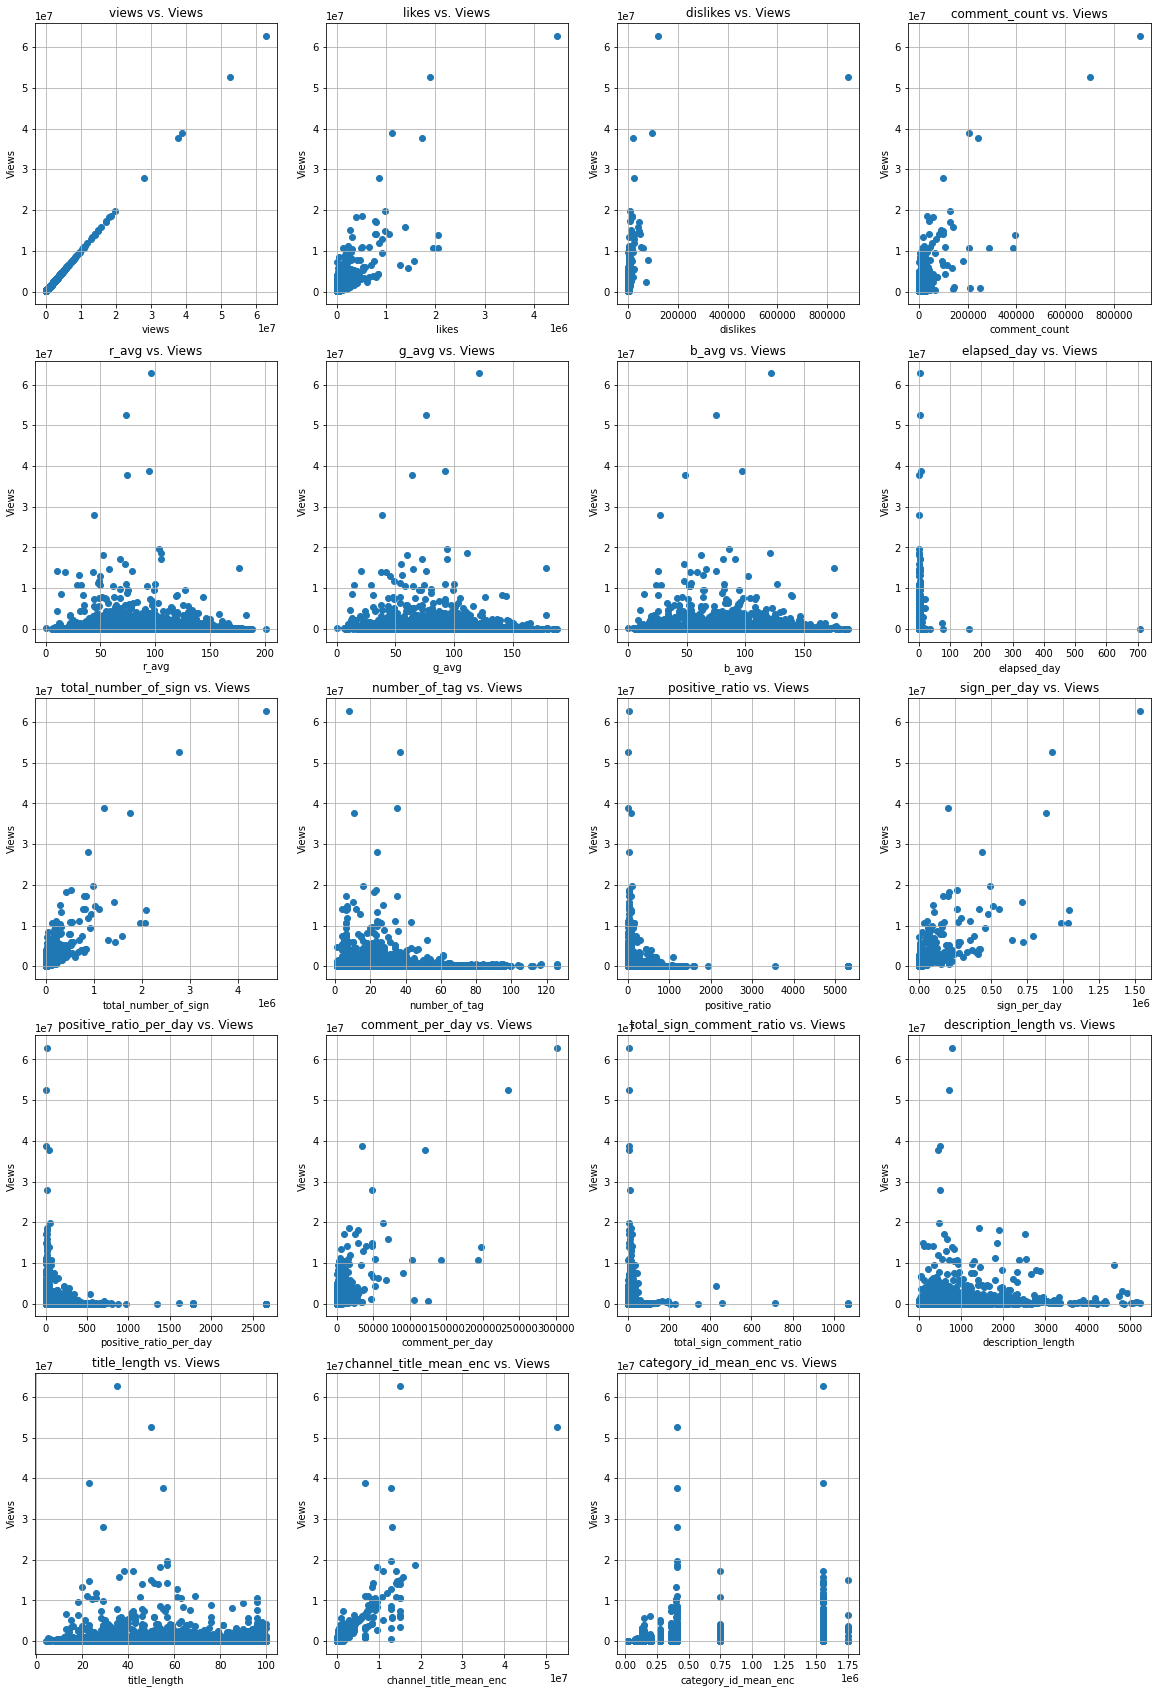

In [31]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

In [32]:
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

                             likes  dislikes  comment_count  r_avg  g_avg  \
likes                     1.000000       NaN            NaN    NaN    NaN   
dislikes                       NaN       1.0            NaN    NaN    NaN   
comment_count                  NaN       NaN       1.000000    NaN    NaN   
r_avg                          NaN       NaN            NaN    1.0    NaN   
g_avg                          NaN       NaN            NaN    NaN    1.0   
b_avg                          NaN       NaN            NaN    NaN    NaN   
elapsed_day                    NaN       NaN            NaN    NaN    NaN   
number_of_tag                  NaN       NaN            NaN    NaN    NaN   
positive_ratio                 NaN       NaN            NaN    NaN    NaN   
sign_per_day              0.976336       NaN            NaN    NaN    NaN   
positive_ratio_per_day         NaN       NaN            NaN    NaN    NaN   
comment_per_day                NaN       NaN       0.973707    NaN    NaN   

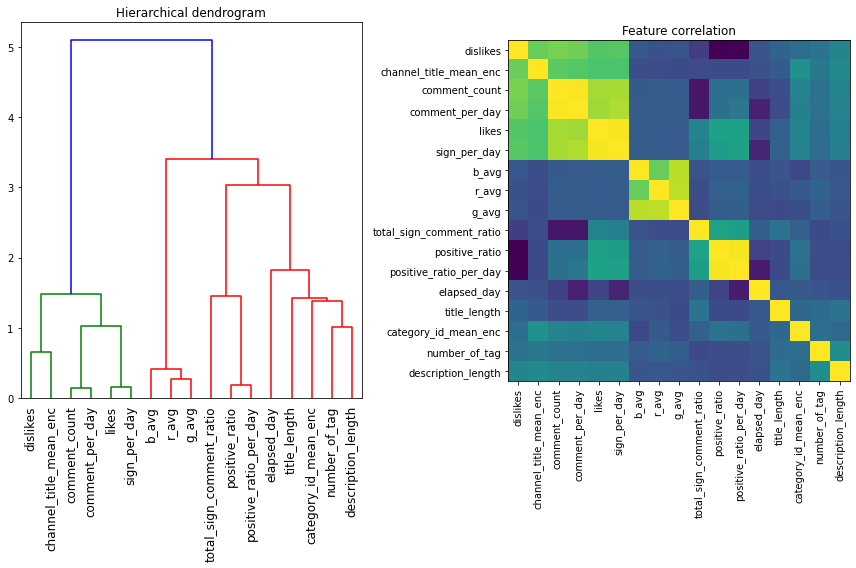

In [33]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features]
cor_table = x_input.corr()

print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

                        likes  dislikes  comment_count  elapsed_day  \
likes                     1.0       NaN            NaN          NaN   
dislikes                  NaN       1.0            NaN          NaN   
comment_count             NaN       NaN            1.0          NaN   
elapsed_day               NaN       NaN            NaN          1.0   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

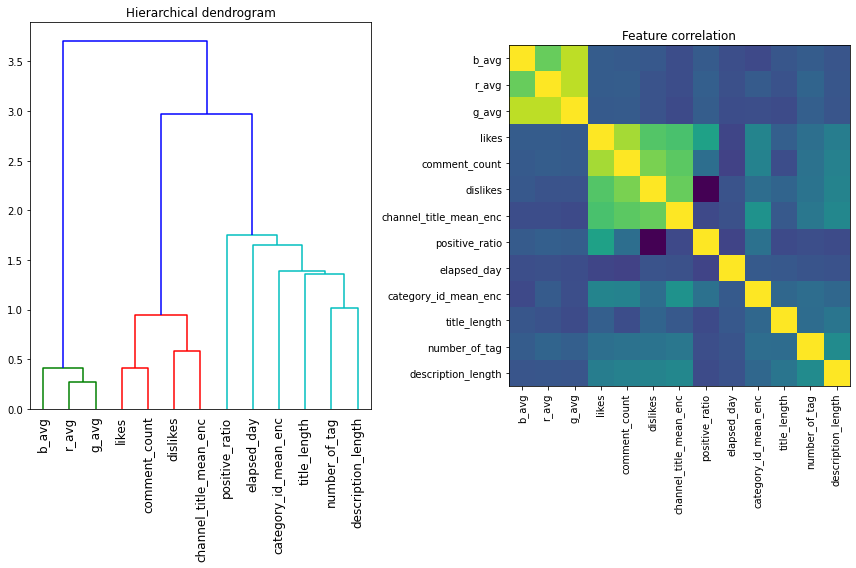

In [ ]:
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [34]:
y_output = df_rgb2['views']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

#**4. 데이터 스케일링**

In [35]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#**5. 모델 생성 및 최적화**

In [36]:
model_name = []
train_perf = []
test_perf = []

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.0008, l1_ratio=0.9900000000000001, max_iter=100000000,
           random_state=42, tol=0.0316)
Best_params: {'alpha': 0.0008, 'l1_ratio': 0.9900000000000001, 'tol': 0.0316}
Best_score: 0.7880139090805345
Train score: 0.8408807282159381
Test  score: 0.654000955308893


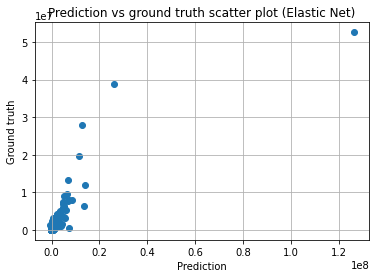

In [37]:
en_model = ElasticNet(max_iter=100000000, random_state=42)

en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}

clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [38]:
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.96, tol=0.1, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=38, n_estimators=116, n_jobs=-1,
                      random_state=42)
Best_params: {'max_depth': 38, 'min_samples_split': 2, 'n_estimators': 116}
Best_score: 0.759844552290743
Train score: 0.9257672159634016
Test  score: 0.5288460165852236


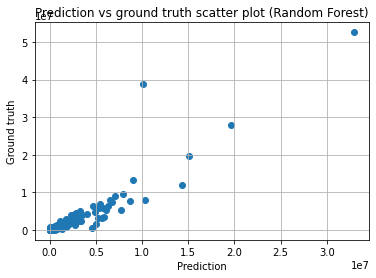

In [39]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [40]:
rf_model = RandomForestRegressor(n_estimators=96, max_depth=34, min_samples_split=3, n_jobs=-1, random_state=42)

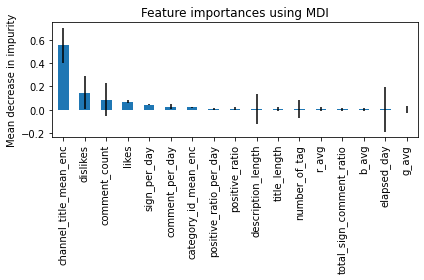

In [41]:
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

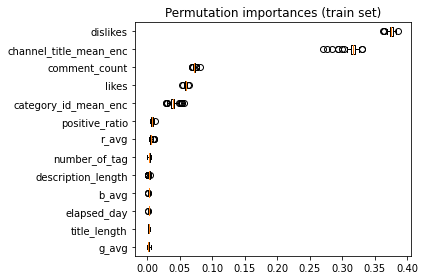

In [ ]:
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished


Best_estimator: MLPRegressor(activation='relu', alpha=0.00011387059213756816, batch_size='auto',
             beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(28, 29, 26, 31), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=2000000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)
Best_params: {'alpha': 0.00011387059213756816, 'hidden_layer_sizes': (28, 29, 26, 31)}
Best_score: 0.5360219562474922
Train score: 0.6721535799313008
Test  score: 0.7515161749302803


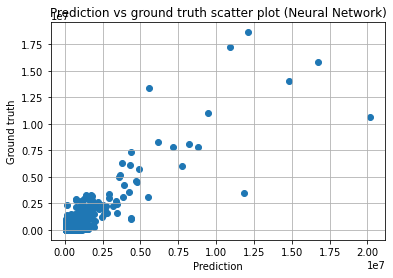

In [ ]:
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=2.715e-4, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   48.4s finished


[23:00:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=120,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0.1, reg_lambda=0.316, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
Best_params: {'max_depth': 2, 'n_estimators': 120, 'reg_alpha': 0.1, 'reg_lambda': 0.316}
Best_score: 0.8223720952696194
Train score: 0.9820184306054018
Test  score: 0.8583923664418808


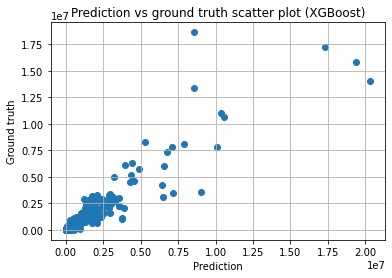

In [ ]:
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=42)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.2min finished


Best_estimator: SVR(C=100000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best_params: {'C': 100000000.0, 'gamma': 0.1}
Best_score: 0.7388959220400236
Train score: 0.66659250504814
Test  score: 0.8492559152109472


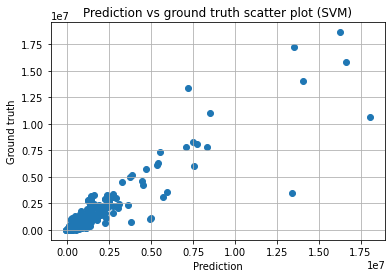

In [ ]:
svr_model = SVR()

svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [ ]:
svr_model = SVR(C=1e8, gamma=0.1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.1s finished


Best_estimator: KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                    weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 3, 'weights': 'distance'}
Best_score: 0.4502175056062224
Train score: 1.0
Test  score: 0.22770469044450914


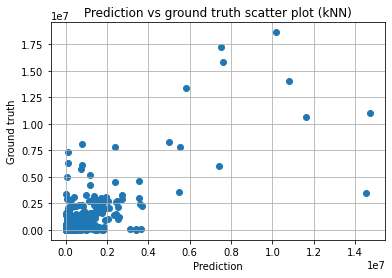

In [ ]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
print('Train score:', r2_score(y_train_pred, y_train))
print('Test  score:', r2_score(y_test_pred, y_test))

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

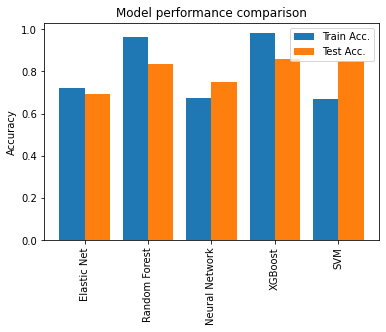

In [ ]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

#**6. 모델 앙상블**

1 Ensemble train score: 0.9967429097656472
1 Ensemble test  score: 0.8751867858547804
2 Ensemble train score: 0.9882698625461269
2 Ensemble test  score: 0.8687625485736389
3 Ensemble train score: 0.9405323971482209
3 Ensemble test  score: 0.8831157732956479
4 Ensemble train score: 0.9118678768570471
4 Ensemble test  score: 0.8724901138777681
5 Ensemble train score: 0.8867348730970719
5 Ensemble test  score: 0.8565692097454212


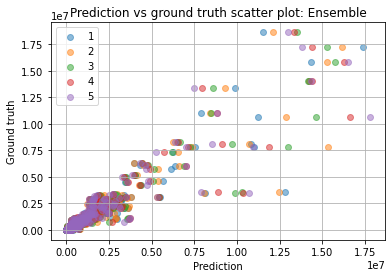

In [ ]:
ensemble_list = [('xgb', xgb_model),
                 ('rf', rf_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [ ]:
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svr_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=4, min_child_weight=1,
                                          missing=None, n_estimators=120,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=42, reg_alpha=0.1,
                                          reg_lambd...
                                                   min_impurity_split=None,
                                                   min_sampl

#**7. 특성(피쳐) 중요도 분석**

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


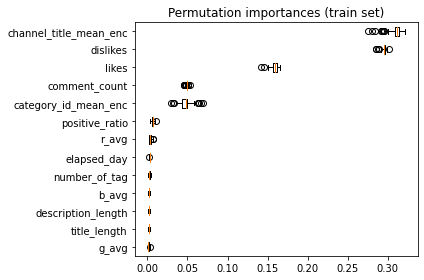

In [ ]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

In [ ]:
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

x_total_scaled = scaler.transform(x_total)

voting_clf.fit(x_total_scaled, y_total)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=4, min_child_weight=1,
                                          missing=None, n_estimators=120,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=42, reg_alpha=0.1,
                                          reg_lambd...
                                                   min_impurity_split=None,
                                                   min_sampl

#**8. 유전 알고리즘 - 최적 피쳐 탐색: 일반 YouTuber**

In [ ]:
df_rgb2['views'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    6.660000e+03
mean     3.679328e+05
std      1.650656e+06
min      2.623000e+03
50%      9.867750e+04
75%      2.331160e+05
90%      5.599660e+05
95%      1.151854e+06
99%      5.137745e+06
max      6.279639e+07
Name: views, dtype: float64

In [ ]:
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'


def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1],
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])],
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

In [ ]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [ ]:
def object_function_median(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = df_rgb2['views'].median()
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [ ]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Streaming output truncated to the last 5000 lines.
Predicted views: 3378884 Difference from target: 3280207
Predicted views: 162797 Difference from target: 64120
Predicted views: 127485 Difference from target: 28807
Predicted views: 1260275 Difference from target: 1161597
Predicted views: 267370 Difference from target: 168692
Predicted views: 170887 Difference from target: 72210
Predicted views: 167230 Difference from target: 68553
Predicted views: 445196 Difference from target: 346518
Predicted views: 199857 Difference from target: 101180
Predicted views: 114691 Difference from target: 16013
Predicted views: 317459 Difference from target: 218782
Predicted views: 9983655 Difference from target: 9884977
Predicted views: 161934 Difference from target: 63256
Predicted views: 1300977 Difference from target: 1202300
Predicted views: 158399 Difference from target: 59721
Predicted views: 6076353 Difference from target: 5977676
Predicted views: 14792542 Difference from target: 14693864
Predict

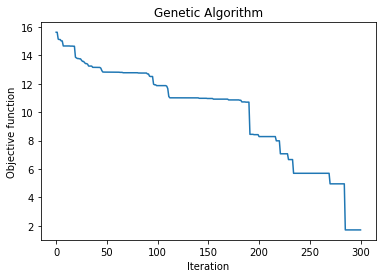

In [ ]:
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

In [ ]:
convergence_median = model_ga_median.report
solution_median = model_ga_median.output_dict

print(convergence_median)
print(solution_median)

[15.635624301692522, 15.635624301692522, 15.15074751792425, 15.121811449781733, 15.121811449781733, 15.021996352084724, 15.021996352084724, 14.667949253016571, 14.667949253016571, 14.667949253016571, 14.667949253016571, 14.667949253016571, 14.667949253016571, 14.667434913883026, 14.659125430183435, 14.659125430183435, 14.659125430183435, 14.649342950207245, 14.649342950207245, 13.877702421603638, 13.823388941836797, 13.78296722142771, 13.78296722142771, 13.761992158286095, 13.761992158286095, 13.65946650350064, 13.580718803977955, 13.580718803977955, 13.492148111290353, 13.425267750512138, 13.425267750512138, 13.383043917510856, 13.25129031075744, 13.25129031075744, 13.25129031075744, 13.25129031075744, 13.162884206578854, 13.162884206578854, 13.162884206578854, 13.162884206578854, 13.162884206578854, 13.162884206578854, 13.162884206578854, 13.155493464911372, 13.106692223805139, 12.933760132052171, 12.83187336638032, 12.826602089137975, 12.826602089137975, 12.826602089137975, 12.82660

In [ ]:
ga_solution = input_conversion(solution_median['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,9806.0,2161.0,5576.0,3.0,111.0,4.537714,1897.0,7.0,53.0,18.0,15.0,12495.0,1.563406e+06


In [ ]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,9806.0,2161.0,5576.0,3.0,111.0,4.537714,1897.0,7.0,53.0,18.0,15.0,KSV eSports,10


In [ ]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,9806.0,2161.0,5576.0,3.0,111.0,4.537714,1897.0,7.0,53.0,18.0,15.0,KSV eSports,Music


In [ ]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_median = ga_solution_df
ga_solution_median

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,9806.0,2161.0,5576.0,3.0,111.0,4.537714,1897.0,7.0,53.0,18.0,15.0,KSV eSports,Music,98683


#**9. 결과 검토 및 분석: 일반 YouTuber**

In [ ]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6660.000000,6.660000e+03,6.660000e+03,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6.660000e+03,6660.000000,6660.000000,6.660000e+03,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6.660000e+03,6.660000e+03
mean,21.178228,3.679328e+05,1.517848e+04,516.760210,2351.420420,94.594595,87.217718,85.692793,2.535285,1.569524e+04,21.761411,107.374173,7.203854e+03,50.651204,1075.410628,9.752234,431.890390,43.293393,3.679328e+05,3.679328e+05
std,6.762678,1.650656e+06,1.029162e+05,11250.755719,18606.078576,31.142526,29.403190,29.615434,12.361518,1.078618e+05,18.008257,416.542044,4.669991e+04,194.373689,7482.807020,47.784162,533.755556,19.589321,1.351592e+06,3.695106e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.410425e+04,6.875000e+02,20.000000,152.000000,74.000000,68.000000,66.000000,2.000000,7.447500e+02,8.000000,14.277114,3.350000e+02,6.419956,67.000000,2.800669,122.000000,28.000000,5.967391e+04,1.296611e+05
50%,24.000000,9.867750e+04,2.041000e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.164000e+03,17.000000,35.345000,1.007500e+03,16.603958,199.166667,5.175674,263.500000,41.000000,1.216400e+05,2.769006e+05
75%,25.000000,2.331160e+05,4.763500e+03,142.000000,1085.000000,116.000000,107.000000,105.000000,2.000000,4.919000e+03,30.000000,79.090295,2.398500e+03,37.909452,518.000000,9.104006,534.000000,55.000000,2.423650e+05,4.098237e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [ ]:
inf_input = copy.deepcopy(model_ga_median)

comment_count_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_median.append([i, int(prediction)])

100%|██████████| 906/906 [01:41<00:00,  8.94it/s]


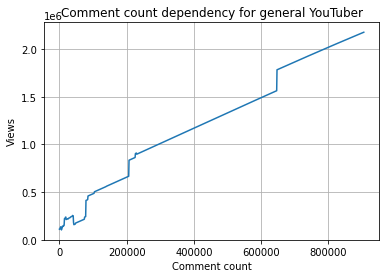

In [ ]:
comment_count_dep_median_df = pd.DataFrame(comment_count_dep_median, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_median_df['comment_count'], comment_count_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

positive_ratio_dep_median = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_median.append([ratio, int(prediction)])

100%|██████████| 500/500 [00:55<00:00,  8.96it/s]


<BarContainer object of 500 artists>

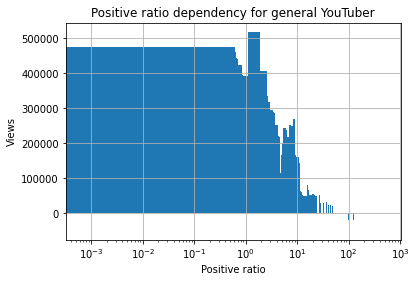

In [ ]:
positive_ratio_dep_median_df = pd.DataFrame(positive_ratio_dep_median, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for general YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

number_of_tag_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_median.append([i, int(prediction)])

100%|██████████| 125/125 [00:13<00:00,  9.02it/s]


<BarContainer object of 125 artists>

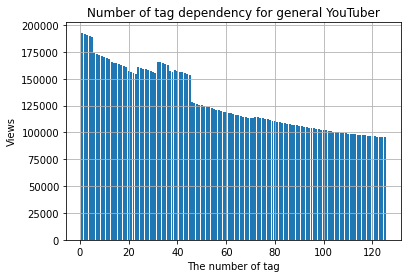

In [ ]:
number_of_tag_dep_median_df = pd.DataFrame(number_of_tag_dep_median, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for general YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_median_df['number_of_tag'], number_of_tag_dep_median_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

random_image_dep_median = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_median.append([i, int(prediction)])

100%|██████████| 2000/2000 [03:44<00:00,  8.92it/s]


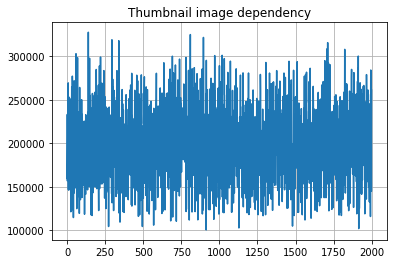

In [ ]:
random_image_dep_median_df = pd.DataFrame(random_image_dep_median, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_median_df['Random_image'], random_image_dep_median_df['Views'])

Average views: 198443.6425
Median views: 198473.0
Standard deviation of views [count]: 41243.876222496634
Standard deviation of views     [%]: 20.78367223202761


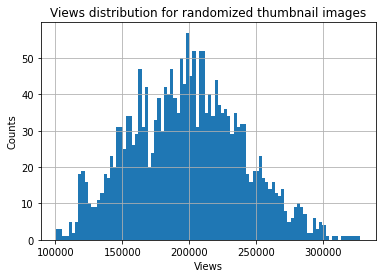

In [ ]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_median_df['Views'], bins=96)

print('Average views:', random_image_dep_median_df['Views'].mean())
print('Median views:', random_image_dep_median_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_median_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_median_df['Views'].std()*100 / random_image_dep_median_df['Views'].mean())

In [ ]:
inf_input = copy.deepcopy(model_ga_median)

channel_title_dep_median = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_median.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████| 1493/1493 [02:46<00:00,  8.97it/s]


<BarContainer object of 1493 artists>

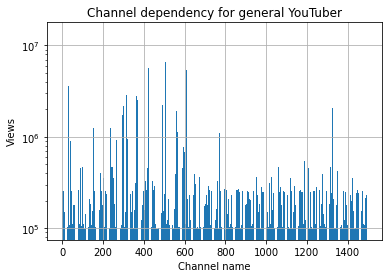

In [ ]:
channel_title_dep_median_df = pd.DataFrame(channel_title_dep_median, columns=['channel_title', 'views'])

plt.title('Channel dependency for general YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_median_df['channel_title'])), channel_title_dep_median_df['views'])

In [ ]:
channel_title_dep_median_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
628,YouTube Spotlight,13933190
179,FoxStarHindi,8100220
52,ArianaGrandeVevo,7499106
681,ibighit,7299564
56,AsapSCIENCE,7266581
552,TaylorSwiftVEVO,6934943
123,ChildishGambinoVEVO,6879442
160,Dude Perfect,6816992
506,Sony Pictures Entertainment,6635716
366,Marvel Entertainment,6560309


Average views: 437887.4527796383
Median views: 205863.0
Standard deviation of views [count]: 988421.4938302735
Standard deviation of views     [%]: 225.7250093730557


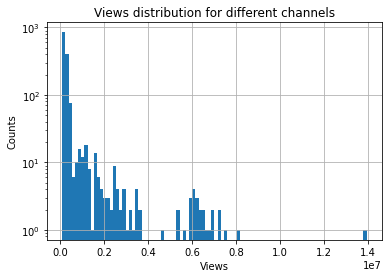

In [ ]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_median_df['views'], bins=96)

print('Average views:', channel_title_dep_median_df['views'].mean())
print('Median views:', channel_title_dep_median_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_median_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_median_df['views'].std()*100 / channel_title_dep_median_df['views'].mean())

#**10. 유전 알고리즘 - 최적 피쳐 탐색: Top YouTuber**

In [ ]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [ ]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [ ]:
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Streaming output truncated to the last 5000 lines.
Predicted views: 51655295 Difference from target: 18344704
Predicted views: 46415046 Difference from target: 23584953
Predicted views: 51250498 Difference from target: 18749501
Predicted views: 52177433 Difference from target: 17822566
Predicted views: 52876001 Difference from target: 17123998
Predicted views: 52372084 Difference from target: 17627915
Predicted views: 48613026 Difference from target: 21386973
Predicted views: 52047448 Difference from target: 17952551
Predicted views: 52372709 Difference from target: 17627290
Predicted views: 47164023 Difference from target: 22835976
Predicted views: 52959204 Difference from target: 17040795
Predicted views: 52582492 Difference from target: 17417507
Predicted views: 52226574 Difference from target: 17773425
Predicted views: 52727837 Difference from target: 17272162
Predicted views: 52995686 Difference from target: 17004313
Predicted views: 52131801 Difference from target: 17868198
Predi

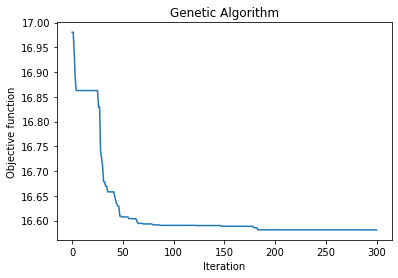

In [ ]:
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()

In [ ]:
convergence_top = model_ga_top.report
solution_top = model_ga_top.output_dict

print(convergence_top)
print(solution_top)

[16.980434526018577, 16.980434526018577, 16.93940035448539, 16.88729841655642, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.862636983319536, 16.829255180751993, 16.829255180751993, 16.740305481471914, 16.72629918802081, 16.70886696846138, 16.67840605473515, 16.67840605473515, 16.66939408828799, 16.66939408828799, 16.65788516217506, 16.65788516217506, 16.65788516217506, 16.65788516217506, 16.65788516217506, 16.65788516217506, 16.65788516217506, 16.648871361736006, 16.639105974150624, 16.633153247282916, 16.62894745438162, 16.62894745438162, 16.608911263125492, 16.608911263125492, 16.60720153975097, 16.60720153975097

In [ ]:
ga_solution = input_conversion(solution_top['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,5025594.0,1040755.0,700412.0,57.0,44.0,4.828796,1527.0,89.0,116.0,106.0,126.0,52611730.0,1.563406e+06


In [ ]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,5025594.0,1040755.0,700412.0,57.0,44.0,4.828796,1527.0,89.0,116.0,106.0,126.0,YouTube Spotlight,10


In [ ]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,5025594.0,1040755.0,700412.0,57.0,44.0,4.828796,1527.0,89.0,116.0,106.0,126.0,YouTube Spotlight,Music


In [ ]:
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_top = ga_solution_df
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,5025594.0,1040755.0,700412.0,57.0,44.0,4.828796,1527.0,89.0,116.0,106.0,126.0,YouTube Spotlight,Music,54113102


#**11. 결과 검토 및 분석: Top YouTuber**

In [ ]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6660.000000,6.660000e+03,6.660000e+03,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6.660000e+03,6660.000000,6660.000000,6.660000e+03,6660.000000,6660.000000,6660.000000,6660.000000,6660.000000,6.660000e+03,6.660000e+03
mean,21.178228,3.679328e+05,1.517848e+04,516.760210,2351.420420,94.594595,87.217718,85.692793,2.535285,1.569524e+04,21.761411,107.374173,7.203854e+03,50.651204,1075.410628,9.752234,431.890390,43.293393,3.679328e+05,3.679328e+05
std,6.762678,1.650656e+06,1.029162e+05,11250.755719,18606.078576,31.142526,29.403190,29.615434,12.361518,1.078618e+05,18.008257,416.542044,4.669991e+04,194.373689,7482.807020,47.784162,533.755556,19.589321,1.351592e+06,3.695106e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.410425e+04,6.875000e+02,20.000000,152.000000,74.000000,68.000000,66.000000,2.000000,7.447500e+02,8.000000,14.277114,3.350000e+02,6.419956,67.000000,2.800669,122.000000,28.000000,5.967391e+04,1.296611e+05
50%,24.000000,9.867750e+04,2.041000e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.164000e+03,17.000000,35.345000,1.007500e+03,16.603958,199.166667,5.175674,263.500000,41.000000,1.216400e+05,2.769006e+05
75%,25.000000,2.331160e+05,4.763500e+03,142.000000,1085.000000,116.000000,107.000000,105.000000,2.000000,4.919000e+03,30.000000,79.090295,2.398500e+03,37.909452,518.000000,9.104006,534.000000,55.000000,2.423650e+05,4.098237e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [ ]:
inf_input = copy.deepcopy(model_ga_top)

comment_count_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_top.append([i, int(prediction)])

100%|██████████| 906/906 [01:40<00:00,  9.02it/s]


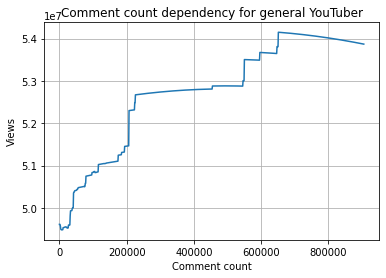

In [ ]:
comment_count_dep_top_df = pd.DataFrame(comment_count_dep_top, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_top_df['comment_count'], comment_count_dep_top_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

positive_ratio_dep_top = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_top.append([ratio, int(prediction)])

100%|██████████| 500/500 [00:55<00:00,  9.04it/s]


<BarContainer object of 500 artists>

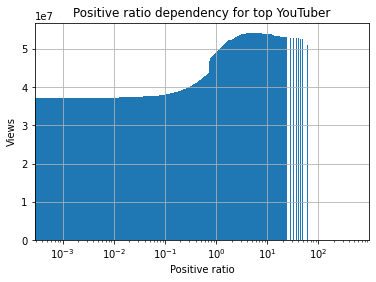

In [ ]:
positive_ratio_dep_top_df = pd.DataFrame(positive_ratio_dep_top, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for top YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_top_df['positive_ratio'], positive_ratio_dep_top_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

number_of_tag_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_top.append([i, int(prediction)])

100%|██████████| 125/125 [00:13<00:00,  9.00it/s]


<BarContainer object of 125 artists>

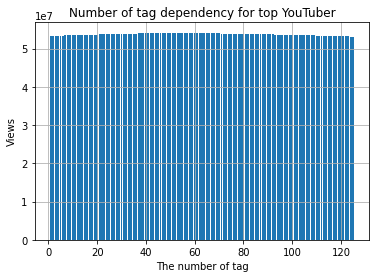

In [ ]:
number_of_tag_dep_top_df = pd.DataFrame(number_of_tag_dep_top, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views'])

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

random_image_dep_top = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_top.append([i, int(prediction)])

100%|██████████| 2000/2000 [03:43<00:00,  8.94it/s]


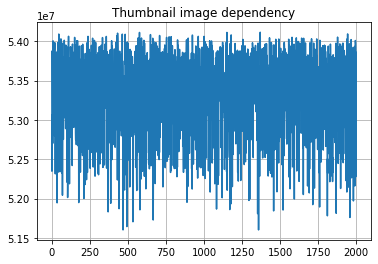

In [ ]:
random_image_dep_top_df = pd.DataFrame(random_image_dep_top, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_top_df['Random_image'], random_image_dep_top_df['Views'])

Average views: 53292985.6115
Median views: 53369109.0
Standard deviation of views [count]: 519110.35775766615
Standard deviation of views     [%]: 0.9740688231316659


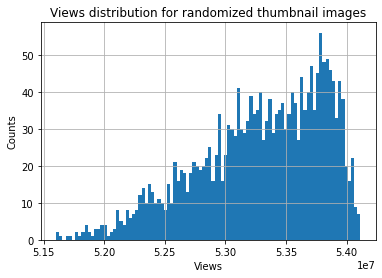

In [ ]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_top_df['Views'], bins=96)

print('Average views:', random_image_dep_top_df['Views'].mean())
print('Median views:', random_image_dep_top_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_top_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_top_df['Views'].std()*100 / random_image_dep_top_df['Views'].mean())

In [ ]:
inf_input = copy.deepcopy(model_ga_top)

channel_title_dep_top = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_top.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████| 1493/1493 [02:44<00:00,  9.05it/s]


<BarContainer object of 1493 artists>

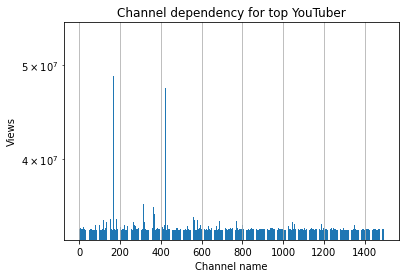

In [ ]:
channel_title_dep_top_df = pd.DataFrame(channel_title_dep_top, columns=['channel_title', 'views'])

plt.title('Channel dependency for top YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_top_df['channel_title'])), channel_title_dep_top_df['views'])

In [ ]:
channel_title_dep_top_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
628,YouTube Spotlight,54113102
179,FoxStarHindi,49823181
52,ArianaGrandeVevo,49387696
681,ibighit,49280591
56,AsapSCIENCE,49253439
552,TaylorSwiftVEVO,49164806
123,ChildishGambinoVEVO,49118949
160,Dude Perfect,49104069
506,Sony Pictures Entertainment,49038333
366,Marvel Entertainment,49003306


Average views: 34249662.72873409
Median views: 33847312.0
Standard deviation of views [count]: 2079843.215115721
Standard deviation of views     [%]: 6.072594733526577


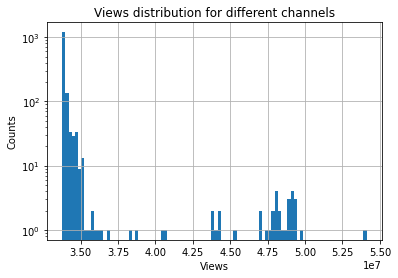

In [ ]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96)

print('Average views:', channel_title_dep_top_df['views'].mean())
print('Median views:', channel_title_dep_top_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_top_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_top_df['views'].std()*100 / channel_title_dep_top_df['views'].mean())

In [ ]:
df_rgb2.sort_values(by='views', ascending=False).head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg,publish_time2,publish_date,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
5659,7C2z4GqqS5E,2018-05-20,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390,4470923,119053,905925,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,96,121,122,2018-05-18,2018-05-18,3,4589976,8,37.554056,1.529992e+06,12.518019,301975.000000,5.066618,784,35,1.517593e+07,1.563406e+06
821,FlsCjmMhFmw,2017-12-08,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",52611730,1891832,884965,702790,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",73,76,75,2017-12-06,2017-12-06,3,2776797,37,2.137748,9.255990e+05,0.712583,234263.333333,3.951105,710,50,5.261173e+07,4.098237e+05
4432,i0p1bmr0EmE,2018-04-14,TWICE What is Love? M/V,jypentertainment,10,2018-04-09T08:59:51.000Z,"TWICE What is Love|""TWICE What is Love?""|""TWIC...",38840787,1111599,96407,206639,https://i.ytimg.com/vi/i0p1bmr0EmE/default.jpg,False,False,False,TWICE(트와이스) What is Love? M/V\n\nSpotify https...,94,92,97,2018-04-09,2018-04-09,6,1208006,35,11.530273,2.013343e+05,1.921712,34439.833333,5.845973,498,23,6.841438e+06,1.563406e+06
560,6ZfuNTqbHE8,2017-11-30,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",37736281,1735938,21972,241242,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,False,False,False,There was an idea… Avengers: Infinity War. In ...,74,64,49,2017-11-29,2017-11-29,2,1757910,11,79.006827,8.789550e+05,39.503413,120621.000000,7.286915,448,55,1.293744e+07,4.098237e+05
4803,u9Mv98Gr5pY,2018-04-25,VENOM - Official Trailer (HD),Sony Pictures Entertainment,24,2018-04-24T03:45:03.000Z,"Venom|""Venom Movie""|""Venom (2018)""|""Marvel""|""M...",27973210,850377,26543,96767,https://i.ytimg.com/vi/u9Mv98Gr5pY/default.jpg,False,False,False,We Are #Venom. 10.5.18\n\nOne of Marvel's most...,44,39,27,2018-04-24,2018-04-24,2,876920,24,32.037712,4.384600e+05,16.018856,48383.500000,9.062180,493,29,1.315249e+07,4.098237e+05
3702,QwievZ1Tx-8,2018-03-17,Marvel Studios' Avengers: Infinity War - Offic...,Marvel Entertainment,24,2018-03-16T13:02:41.000Z,"marvel|""comics""|""comic books""|""nerd""|""geek""|""s...",19716689,975760,9120,127045,https://i.ytimg.com/vi/QwievZ1Tx-8/default.jpg,False,False,False,In theaters April 27. Get your tickets now: ht...,103,94,86,2018-03-16,2018-03-16,2,984880,16,106.991228,4.924400e+05,53.495614,63522.500000,7.752214,474,57,1.293744e+07,4.098237e+05
4840,rRr1qiJRsXk,2018-04-25,Sanju | Official Teaser | Ranbir Kapoor | Rajk...,FoxStarHindi,24,2018-04-24T07:58:08.000Z,"Sanju Teaser|""Official Teaser""|""Sanju Official...",18639195,511785,15607,32435,https://i.ytimg.com/vi/rRr1qiJRsXk/default.jpg,False,False,False,Few lives in our times are as dramatic and eni...,105,111,121,2018-04-24,2018-04-24,2,527392,23,32.792016,2.636960e+05,16.396008,16217.500000,16.259966,1414,57,1.863920e+07,4.098237e+05
854,vn9mMeWcgoM,2017-12-09,Jurassic World: Fallen Kingdom - Official Trai...,Universal Pictures,24,2017-12-08T01:44:25.000Z,"Jurassic World|""Fallen Kingdom""|""Jurassic Park...",18184886,399208,17473,58902,https://i.ytimg.com/vi/vn9mMeWcgoM/default.jpg,False,False,False,Jurassic World: Fallen Kingdom\nIn Theaters Ju...,52,60,62,2017-12-08,2017-12-08,2,416681,22,22.847136,2.083405e+05,